In [43]:
import os
import multiprocessing

from json import loads

# from time import sleep
import pandas as pd
import kblab 
import math
from pandas.core.frame import DataFrame
from tqdm import tqdm
from urllib3.util import Retry
from urllib3 import PoolManager, make_headers
from kblab import Archive
import regex as re
from itertools import product
kblab.VERIFY_CA=False

In [44]:
years = range(1920, 1930)

In [45]:
df: DataFrame = pd.read_feather("data/all_metadata_1920s.feather")

In [46]:
df

,created,year,edition,issue,title,dark_id
0,1923-07-14,1923,11632,187,SVENSKA DAGBLADET,dark-102398
1,1923-07-17,1923,11632,190,SVENSKA DAGBLADET,dark-102396
2,1923-07-13,1923,11632,186,SVENSKA DAGBLADET,dark-102395
3,1923-07-31,1923,11632,204,SVENSKA DAGBLADET,dark-102412
4,1923-07-15,1923,11632,188,SVENSKA DAGBLADET,dark-102405
...,...,...,...,...,...,...
10664,1922-05-23,1922,0,s,AFTONBLADET,dark-44912
10665,1922-05-24,1922,11161,138,DAGENS NYHETER,dark-4204256
10666,1922-05-23,1922,11161,137,DAGENS NYHETER,dark-4204239
10667,1922-05-24,1922,0,s,AFTONBLADET,dark-44911


In [47]:
df_content: DataFrame = pd.read_feather("data/df_content_1920s.feather")

In [48]:
df_content.loc[0]

content    Nr 187  ASEA  BTOCKHOLMSIJPPLAGA (Uppi A  Elek...
dark_id                                          dark-102398
title                                      SVENSKA DAGBLADET
created                                           1923-07-14
Name: 0, dtype: object

In [49]:

regex = r"\p{L}+"
def tokenize(text):
  return re.finditer(regex, text.lower())

In [50]:
def text_to_idx(words):
  wordCount = 0
  wordPos = {}
  for token in words:
    wordCount+=1
    word = token.group()
    pos = token.span()[0]
    if word in wordPos.keys():
      wordPos[word].append(pos)
    else:
      wordPos[word] = [pos]
  return wordPos, wordCount

In [51]:
tokens = tokenize("Men hallå där!")
idx, wordCount = text_to_idx(tokens)
print(wordCount)
idx.keys()

3


dict_keys(['men', 'hallå', 'där'])

In [179]:
def getDeclension(word):
  if word[-1:] == "t":
    root = word[:-1]
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-1:] == "a":
    root = word[:-1]
    return [word, f"{root}an", f"{root}or", f"{root}orna"]
  if word[-2:] == "yr":
    root = word[:-1]
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "r" and not word[-2:] == "är":
    root = word[:-1]
    return [word, f"{word}et", f"{word}", f"{word}en"]
  if word[-1:] == "d":
    root = word[:-3]
    return [word, f"{word}et", f"{root}änder", f"{root}änderna"]
  if word[-3:] == "are":
    root = word[:-1]
    return [word, f"{root}en", f"{root}e", f"{root}na"]
  if word[-2:] == "re":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-1:] == "e":
    root = word[:-1]
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "ll":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}ar", f"{word}arna"]
  if word[-1:] == "l":
    root = word[:-2] 
    return [word, f"{root}eln", f"{root}lar", f"{root}larna"]
  if word[-2:] == "ag":
    root = word 
    return [word, f"{root}et", f"{root}", f"{root}en"]
  if word[-1:] == "g":
    root = word 
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]
  if word[-2:] == "um":
    root = word[:-2] 
    return [word, f"{root}en", f"{root}nar", f"{root}narna"]
  if word[-2:] == "en":
    root = word[:-2] 
    return [word, f"{root}nen", f"{root}er", f"{root}erna"]
  if word[-2:] == "ur" or word[-2:] == "är":
    root = word[:-2] 
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  if word[-2:] == "nd":
    root = word[:-3]
    return [word, f"{word}en", f"{root}änder", f"{word}änderna"]
  if word[-1:] == "ö":
    return [word, f"{word}n", f"{word}ar", f"{word}arna"]
  if word[-1:] == "k":
    return [word, f"{word}en", f"{word}er", f"{word}erna"]
  else:
    root = word
    return [word, f"{root}en", f"{root}ar", f"{root}arna"]


In [180]:
birds = pd.read_csv("birds.csv", header=0)
natureTypes = pd.read_csv("naturtyper.csv", header=0)
wordChecklist = natureTypes.copy()
natureTypes.iloc[0]["naturtyp"]
birds

,svenskt namn,bengelskt namn
0,fågel,bird
1,aftonfalk,falco vespertinus
2,alfågel,clangula hyemalis
3,alförrädare,polysticta stelleri
4,alkekung,alle alle
...,...,...
531,ökentrumpetare,bucanetes githagineus
532,ökenvarfågel,lanius elegans
533,örnvråk,buteo rufinus
534,östlig kronsångare,phylloscopus coronatus


In [181]:


def addWords(word, onlyDeclension = True): 
    global wordChecklist
    if onlyDeclension:
        wordDec = getDeclension(word)[1:]
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2]], columns=["naturtyp"])
    else:
        wordDec = getDeclension(word)
        wordDecFrame = pd.DataFrame([wordDec[0],wordDec[1],wordDec[2],wordDec[3]], columns=["naturtyp"])
    wordChecklist = pd.concat([wordChecklist,wordDecFrame])


In [182]:

natureTypes["naturtyp"].apply(lambda x: addWords(x, onlyDeclension=False))
print(wordChecklist)


                        naturtyp
0                       sandbank
1                      estuarium
2                     sandbotten
3                      lerbotten
4   blottade ler- och sandbotten
..                           ...
3                svämlövskogarna
0                svämädellövskog
1              svämädellövskogen
2              svämädellövskogar
3            svämädellövskogarna

[610 rows x 1 columns]


In [186]:
wordChecklistList = wordChecklist["naturtyp"].tolist()
print(wordChecklistList)

['sandbank', 'estuarium', 'sandbotten', 'lerbotten', 'blottade ler- och sandbotten', 'lagun', 'vik', 'sund', 'rev', 'bubbelstruktur', 'driftvall', 'stenvall ', 'grusvall', 'havsklippa', 'strand', 'glasörtstrand', 'salta strandäng', 'ö', 'åsö', 'skär', 'strandäng', 'smala östersjövik', 'dyn', 'fördyn', 'vita dyn', 'grå dyn', 'risdyner', 'sandvidedyn', 'trädklädda dyn', 'dynvåtmark', 'hed', 'rissandhed', 'grässandhedar', 'sjö', 'slättssjö', 'näringsfattiga slättssjöar', 'ävjestrandsjö', 'kransalgssjö', 'näringsrika sjö', 'näringsrik sjö', 'naturligt näringsrika sjö', 'myrsjö', 'vattendrag', 'större vattendrag', 'alpina vattendrag', 'mindre vattendrag', 'fukthed', 'torra hed', 'alpina rished', 'alpina videbuskmark', 'enbuskmark', 'berghäll', 'basiska berghäll', 'sandstäpp', 'mark', 'gräsmark', 'silikatgräsmark', 'alpina silikatgräsmark', 'alpina kalkgräsmark', 'kalkgräsmark', 'stagg-gräsmark', 'alv', 'älv', 'äng', 'fuktäng', 'högörtäng', 'svämäng', 'lågland', 'slåtteräng', 'slåtterängar i

In [56]:
from transformers import AutoModel,pipeline

ner = pipeline('ner', model='KB/bert-base-swedish-cased-ner', tokenizer='KB/bert-base-swedish-cased-ner')
pos = pipeline("token-classification", model="KBLab/bert-base-swedish-cased-pos", tokenizer="KBLab/bert-base-swedish-cased-pos")



Some weights of the model checkpoint at KB/bert-base-swedish-cased-ner were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at KBLab/bert-base-swedish-cased-pos were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with anoth

In [146]:
ner('Fågeln såldes för 20 kr i stockholm')

[{'entity': 'MSR',
  'score': 0.9998677,
  'index': 5,
  'word': '20',
  'start': 18,
  'end': 20},
 {'entity': 'MSR',
  'score': 0.99980706,
  'index': 6,
  'word': 'kr',
  'start': 21,
  'end': 23},
 {'entity': 'LOC',
  'score': 0.93577737,
  'index': 8,
  'word': 'stockholm',
  'start': 26,
  'end': 35}]

In [192]:
def getVerbs(text):
    posText = pos(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] == "VB", l))]

In [193]:
def getNamed(text):
    interestingTags = ["PRS", "LOC", "ORG", "OBJ"]
    posText = ner(text)
    l = []
    for token in posText:
        try:
            if token['word'].startswith('##'):
                l[-1]['word'] += token['word'][2:]
            else:
                l += [ token ]
        except:
            print(f"failed with {token}")
    return [x["word"] for x in list(filter(lambda d: d['entity'] in interestingTags, l))]    

In [159]:

text = 'Engelbert tar Volvon till Tele2 Arena för att tittade på Djurgården IF ' +\
       'som spelar fotboll i VM klockan två på kvällen.'
tmp = getVerbs(text)
print(tmp)


['tar', 'tittade', 'spelar']


In [160]:
tmp = getNamed(text)
print(tmp)

['Tele2', 'Arena', 'Djurgården', 'IF']


In [80]:

master_index = {}
yearCounts = {}

for y in years:
    yearCounts.update({str(y):0})
totalCount = 0
tmp = 0

def addToIndex(row):
    global master_index
    tokens = tokenize(row["content"])
    idx, wordCount = text_to_idx(tokens)
    year = row["created"][:4]
    yearCounts[year] += wordCount
    for word in idx.keys():
        #if word in wordChecklist["svenskt namn"].values:
            if word in master_index:
                master_index[word][row["dark_id"], year] = idx[word]
            else:
                master_index[word] = {(row["dark_id"], year):idx[word]}
        


In [81]:
len(master_index)

0

In [82]:
df_content.head(1000).apply(lambda row: addToIndex(row), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Length: 1000, dtype: object

In [ ]:
master_index

In [83]:
def counter(word):
  master_index_bird = master_index[word]
  count = {}

  for y in years:
    count.update({str(y): {"freq":0, "count":0, "prob":0}})
  for a,b in master_index_bird:
    if b in count:
      count[b]["count"] += 1
    else:
      count[b]["count"] = 1
  for y in years:
    try:
      count[str(y)]["freq"] = count[str(y)]["count"]/yearCounts[str(y)]*100000
      count[str(y)]["prob"] = count[str(y)]["count"]/yearCounts[str(y)]
    except:
      count[str(y)]["freq"] = 0.0
  return count


In [94]:
counter("fågel")

{'1920': {'freq': 0.0, 'count': 0, 'prob': 0},
 '1921': {'freq': 0.0, 'count': 0, 'prob': 0},
 '1922': {'freq': 0.684597804494841, 'count': 6, 'prob': 6.84597804494841e-06},
 '1923': {'freq': 0.33915952877175076,
  'count': 4,
  'prob': 3.3915952877175074e-06},
 '1924': {'freq': 0.6829248304639108,
  'count': 21,
  'prob': 6.829248304639108e-06},
 '1925': {'freq': 0.8574454128814024,
  'count': 4,
  'prob': 8.574454128814024e-06},
 '1926': {'freq': 0.5743338169518603,
  'count': 104,
  'prob': 5.743338169518602e-06},
 '1927': {'freq': 0.5632992660461716,
  'count': 157,
  'prob': 5.632992660461716e-06},
 '1928': {'freq': 0.5432630473129751,
  'count': 83,
  'prob': 5.432630473129751e-06},
 '1929': {'freq': 0.5279607345042535,
  'count': 40,
  'prob': 5.279607345042535e-06}}

In [203]:
yearsString = [str(y) for y in range(1920, 1930)]


def getWordCooccurence(word):
  cooccurence = {}
  for y in range(1920, 1930):
    cooccurence.update({str(y):{}})
  for issue, year in master_index[word]:
    birdRow = df_content.loc[df_content["dark_id"] == issue]
    textBlock = birdRow["content"].values[0].replace(",", "")
    n = 10
    lhs, _, rhs = textBlock.partition(word)
    window = lhs.split()[-n:] + rhs.split()[:n]
    birdWords = list(filter(None, window))
    tmp = " ".join(birdWords)
    verbs = getVerbs(tmp)
    named = getNamed(tmp)
    natureWords = [k for k in birdWords if k in wordChecklistList]
    interestingWords = verbs + named + natureWords
    for bWord in interestingWords:
      if bWord == word or bWord in yearsString:
        continue
      if bWord in cooccurence[year]:
        cooccurence[year][bWord] += 1
      else:
        cooccurence[year][bWord] = 1
      
      
  return cooccurence

In [143]:
def sortCooccurence(a):
  return sorted(a.items(), key=lambda x:x[1], reverse=True)

In [196]:
counter("fågel")["1922"]

{'freq': 0.684597804494841, 'count': 6, 'prob': 6.84597804494841e-06}

In [204]:
getWordCooccurence("fågel")


failed with {'entity': 'LOC', 'score': 0.58660275, 'index': 14, 'word': '##hai', 'start': 63, 'end': 66}
failed with {'entity': 'ORG', 'score': 0.52943987, 'index': 8, 'word': '##lies', 'start': 25, 'end': 29}
failed with {'entity': 'PER', 'score': 0.6161911, 'index': 6, 'word': '##äss', 'start': 21, 'end': 24}
failed with {'entity': 'PER', 'score': 0.6384266, 'index': 31, 'word': '##ox', 'start': 120, 'end': 122}
failed with {'entity': 'PER', 'score': 0.75472087, 'index': 13, 'word': '##kull', 'start': 42, 'end': 46}
failed with {'entity': 'PER', 'score': 0.5596368, 'index': 2, 'word': '##in', 'start': 2, 'end': 4}
failed with {'entity': 'PER', 'score': 0.7407312, 'index': 3, 'word': '##hö', 'start': 8, 'end': 10}
failed with {'entity': 'PER', 'score': 0.6529663, 'index': 10, 'word': '##åk', 'start': 31, 'end': 33}


{'1920': {},
 '1921': {},
 '1922': {'sade': 1,
  'drogo': 1,
  'är': 1,
  'söker': 1,
  'gå': 2,
  'se': 1,
  'låt': 1,
  'beställa': 1,
  'inkommer': 1},
 '1923': {'sätter': 1,
  'bliv': 1,
  'slår': 1,
  'slagit': 1,
  'spela': 1,
  'stiger': 1,
  'doftar': 1,
  'marker': 1,
  'ängar': 1,
  'har': 1,
  'låg': 1,
  'Uttryckte': 1,
  'är': 1},
 '1924': {'kunde': 1,
  'möjliggöra': 1,
  'kallas': 1,
  'är': 4,
  'har': 1,
  'utställt': 1,
  'stå': 1,
  'kan': 1,
  'vara': 1,
  'emigrera': 1,
  'bliva': 1,
  'skall': 1,
  'ha': 2,
  'foster': 1,
  'lyckades': 1,
  'flyga': 1,
  'utvecklade': 1,
  'förlorade': 1,
  'skriva': 1,
  'Norr': 1,
  'Vasa': 1,
  'ligger': 1,
  'känner': 1,
  'var': 3,
  'tala': 1,
  'Sthlm': 1,
  'Birgerjarlsgatan': 1,
  'S2': 1,
  'Svara': 1,
  'blivit': 1,
  'förefaller': 1,
  'vore': 1,
  'St': 1,
  'Nygatan': 1,
  'Oxtorgsgatan': 1,
  '7': 1,
  'Stockholm': 1,
  'sett': 1,
  'gick': 1,
  'säljes': 1,
  'sjö': 1},
 '1925': {'Kungsgatan': 1,
  '45': 1,
  'Karl

In [205]:
sortCooccurence(getWordCooccurence("fågel")["1927"])

failed with {'entity': 'LOC', 'score': 0.58660275, 'index': 14, 'word': '##hai', 'start': 63, 'end': 66}
failed with {'entity': 'ORG', 'score': 0.52943987, 'index': 8, 'word': '##lies', 'start': 25, 'end': 29}
failed with {'entity': 'PER', 'score': 0.6161911, 'index': 6, 'word': '##äss', 'start': 21, 'end': 24}
failed with {'entity': 'PER', 'score': 0.6384266, 'index': 31, 'word': '##ox', 'start': 120, 'end': 122}
failed with {'entity': 'PER', 'score': 0.75472087, 'index': 13, 'word': '##kull', 'start': 42, 'end': 46}
failed with {'entity': 'PER', 'score': 0.5596368, 'index': 2, 'word': '##in', 'start': 2, 'end': 4}
failed with {'entity': 'PER', 'score': 0.7407312, 'index': 3, 'word': '##hö', 'start': 8, 'end': 10}
failed with {'entity': 'PER', 'score': 0.6529663, 'index': 10, 'word': '##åk', 'start': 31, 'end': 33}


[('är', 21),
 ('har', 14),
 ('hade', 9),
 ('var', 8),
 ('ha', 6),
 ('teatern', 5),
 ('Sicilien', 4),
 ('Dramatiska', 4),
 ('skulle', 4),
 ('få', 4),
 ('varit', 4),
 ('Stockholm', 3),
 ('vara', 3),
 ('vet', 3),
 ('finnes', 3),
 ('vill', 3),
 ('kände', 3),
 ('skogen', 3),
 ('skall', 3),
 ('gläder', 3),
 ('slå', 2),
 ('Har', 2),
 ('Radiotjänst', 2),
 ('låt', 2),
 ('Oscarsteatern', 2),
 ('sjöng', 2),
 ('flög', 2),
 ('kommer', 2),
 ('riksdagen', 2),
 ('kan', 2),
 ('Köpenhamn', 2),
 ('Hör', 2),
 ('sjö', 2),
 ('kunna', 2),
 ('sjön', 2),
 ('Vita', 2),
 ('haft', 2),
 ('häckar', 2),
 ('a', 2),
 ('gå', 2),
 ('STOCKHOLM', 2),
 ('känt', 2),
 ('ägt', 2),
 ('fått', 2),
 ('skär', 2),
 ('pröva', 2),
 ('skog', 2),
 ('längtar', 2),
 ('flögo', 1),
 ('voro', 1),
 ('snuddade', 1),
 ('nämna', 1),
 ('påträffade', 1),
 ('åstadkomma', 1),
 ('avslutas', 1),
 ('står', 1),
 ('Chemnitz', 1),
 ('svingar', 1),
 ('Sverige', 1),
 ('Svenska', 1),
 ('Telegrambyråns', 1),
 ('Annonsavdelning', 1),
 ('visade', 1),
 ('märkte

In [114]:
def mergeCounts(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {"freq": c1[str(y)]["freq"] + c2[str(y)]["freq"], "count": c1[str(y)]["count"] + c2[str(y)]["count"], "prob": c1[str(y)]["prob"] + c2[str(y)]["prob"]}
  return tmp


In [115]:
def mergeCoocs(c1, c2):
  tmp = {}
  for y in years:
    tmp[str(y)] = {k: (c1[str(y)].get(k, 0) + c2[str(y)].get(k, 0)) for k in set(c1[str(y)]) | set(c2[str(y)])}
  return tmp

In [206]:
tmp = 0

frequency = {}
cooccurenceMatrix = {}

for i, bird in birds.iterrows():
  specificbird = bird["svenskt namn"]
  birds_dec = getDeclension(specificbird)
  for bd in birds_dec:
    try:
      bc = counter(bd)
      if bird[0] in frequency:
        freq = frequency[specificbird]
      else:
        freq = {}
        for y in yea
        rs:
          freq.update({str(y):{"freq":0, "count":0, "prob":0}})
      frequency[specificbird] = mergeCounts(bc, freq)

      if specificbird in cooccurenceMatrix:
        co = cooccurenceMatrix[specificbird]
        coWord = getWordCooccurence(bd)
        cooccurenceMatrix[specificbird] = mergeCoocs(co, coWord)
      else:
        cooccurenceMatrix[specificbird] = getWordCooccurence(bd)
    except:
      "lmao"
  

/tmp/ipykernel_326235/3679754970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if bird[0] in frequency:


failed with {'entity': 'LOC', 'score': 0.58660275, 'index': 14, 'word': '##hai', 'start': 63, 'end': 66}
failed with {'entity': 'ORG', 'score': 0.52943987, 'index': 8, 'word': '##lies', 'start': 25, 'end': 29}
failed with {'entity': 'PER', 'score': 0.6161911, 'index': 6, 'word': '##äss', 'start': 21, 'end': 24}
failed with {'entity': 'PER', 'score': 0.6384266, 'index': 31, 'word': '##ox', 'start': 120, 'end': 122}
failed with {'entity': 'PER', 'score': 0.75472087, 'index': 13, 'word': '##kull', 'start': 42, 'end': 46}
failed with {'entity': 'PER', 'score': 0.5596368, 'index': 2, 'word': '##in', 'start': 2, 'end': 4}
failed with {'entity': 'PER', 'score': 0.7407312, 'index': 3, 'word': '##hö', 'start': 8, 'end': 10}
failed with {'entity': 'PER', 'score': 0.6529663, 'index': 10, 'word': '##åk', 'start': 31, 'end': 33}
failed with {'entity': 'PER', 'score': 0.84743166, 'index': 12, 'word': '##mi', 'start': 27, 'end': 29}
failed with {'entity': 'LOC', 'score': 0.83561826, 'index': 22, 'wor

In [117]:
frequency

{'fågel': {'1920': {'freq': 0.0, 'count': 0, 'prob': 0},
  '1921': {'freq': 0.0, 'count': 0, 'prob': 0},
  '1922': {'freq': 1.369195608989682,
   'count': 12,
   'prob': 1.369195608989682e-05},
  '1923': {'freq': 1.4414279972799409,
   'count': 17,
   'prob': 1.4414279972799408e-05},
  '1924': {'freq': 1.8536531112591865,
   'count': 57,
   'prob': 1.8536531112591864e-05},
  '1925': {'freq': 2.1436135322035064,
   'count': 10,
   'prob': 2.143613532203506e-05},
  '1926': {'freq': 1.8003156185221771,
   'count': 326,
   'prob': 1.8003156185221772e-05},
  '1927': {'freq': 1.5930246759522306,
   'count': 444,
   'prob': 1.5930246759522305e-05},
  '1928': {'freq': 1.5577904248251575,
   'count': 238,
   'prob': 1.5577904248251577e-05},
  '1929': {'freq': 1.6762753320510047,
   'count': 127,
   'prob': 1.6762753320510047e-05}},
 'alfågel': {'1920': {'freq': 0.0, 'count': 0, 'prob': 0},
  '1921': {'freq': 0.0, 'count': 0, 'prob': 0},
  '1922': {'freq': 0.0, 'count': 0, 'prob': 0.0},
  '1923'

In [112]:
def getTScore(bird, year):
  ts = {}
  skipwords = ["och", "i", "en", "som", "att", "kan", "den", "ett"]
  for word, count_co in cooccurenceMatrix[bird][year].items():
    if word in skipwords:
      continue
    try:
      count_word = counter(word)[year]["count"]
      prob_word = count_word/yearCounts[year] *100000
      prob_bird = frequency[bird][year]["freq"]
      prob_both = count_co/yearCounts[year] * 100000

      ts[word] = ((
        prob_both -
        prob_bird *
        prob_word /
        yearCounts[year] /
        math.sqrt(prob_both)
      ))
    except:
      "lmao"
  return sorted(ts.items(), key=lambda x:x[1], reverse=True)[:10]
  

In [75]:
def getPMIs(bird, year):
  tmp = []
  count_bird = frequency[bird][year]["count"]
  #print("count b\t", count_bird)
  prob_bird = frequency[bird][year]["prob"]
  #print("prob b\t", prob_bird)
  i = 0
  for word, count_co in cooccurenceMatrix["Domherre"][year].items():
    try:
      print(word)
      i+=1
      if i > 5:
        break; 
      count_word = counter(word)[year]["count"]
      #print("count w\t", count_word)
      prob_word = count_word/yearCounts[year]
      #print("prob w\t", prob_word)
      #print("count co w\t", count_co)
      prob = count_co/yearCounts[year]
      #print("total prob\t", prob)
      pmi = max(math.log(prob/(prob_bird*prob_word)),0)
      #print("pmi\t", pmi)
      tmp.append((word, pmi))
      #print()
    except:
      "oof"
  return sorted(tmp, key=lambda x:x[1], reverse=True)

In [199]:
counter("korp")["1926"]["count"]

15

In [118]:
cooccurenceMatrix["fågel"]["1922"]

{'hörde': 1,
 '3': 2,
 'roligt': 1,
 'en': 1,
 'de': 2,
 'där': 1,
 'flyga': 1,
 'Jagen': 1,
 'skaffa': 1,
 '75—': 1,
 'och': 3,
 'endast': 1,
 'gräs': 1,
 'Där': 1,
 'Zoologiska': 1,
 'gå': 1,
 'skinnet': 2,
 'gevär': 1,
 'kokt': 1,
 'Bästa': 1,
 'beställa': 1,
 'passat': 1,
 'pristagare': 1,
 'Aldrig': 2,
 'fred': 1,
 'j': 1,
 'övervunnit': 1,
 'Lill': 1,
 'ett': 1,
 'Signaturen': 1,
 'så': 3,
 'slagdänga': 1,
 'sig': 4,
 'trollsländeflicka': 1,
 'n': 1,
 'är': 2,
 'spann': 1,
 'glatt': 1,
 'N': 1,
 'afton': 1,
 'se': 1,
 'öre': 1,
 'ängars': 1,
 'bland': 1,
 'blomsterfången': 1,
 'över': 1,
 'kring': 1,
 'lilla': 1,
 'levande': 1,
 '^yARUMÅRKELi': 1,
 'sina': 1,
 'genom': 1,
 'W2m': 1,
 'gången': 1,
 'par': 1,
 'inte': 3,
 'hängd': 1,
 'Att': 1,
 'älgskyttar': 1,
 'i': 3,
 'gångs': 1,
 'igen': 1,
 'dagligen': 1,
 'o': 1,
 'honom': 2,
 "'i": 1,
 '—': 3,
 'han': 4,
 'ritade': 1,
 'besöker': 1,
 'fisk': 1,
 'Föregående': 1,
 '5': 1,
 'räv': 1,
 'längre': 1,
 'klänningar': 1,
 'min': 1,

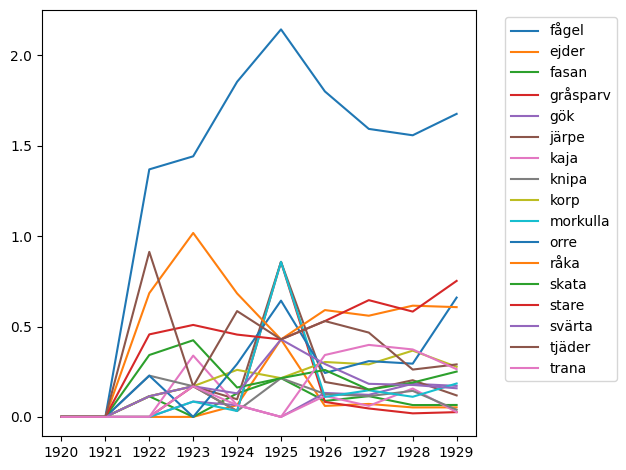

In [119]:
import matplotlib.pyplot as plt
import numpy as np
tmp = 0

for bird, freq in frequency.items():
  tmp +=1
  onlyFreqs = {}
  avg = 0
  for f in freq:
    onlyFreqs.update({str(f): freq[f]["freq"]})
    avg += freq[f]["freq"]/10
  if avg > 0.05:
    plt.plot(onlyFreqs.keys(), onlyFreqs.values(), label=bird)



plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()


In [138]:
wordSearches = ["Stockholm", "Göteborg", "morgon", "natt", "skola", "land", "hafvet"]

In [140]:
print("bird\t| Stockholm \t| Göteborg \t| morgon \t| natt \t| skola | land \t| hafvet \t|")
for bird, freq in frequency.items():
  srt = {k: v for k, v in sorted(freq.items(), key=lambda item: item[0])}
  if frequency[bird]["1925"]["freq"] > 0.25:
    wordCounts = [0,0,0,0,0,0,0]
    for i,ws in enumerate(wordSearches):
      try:
        wordCounts[i] = cooccurenceMatrix[bird].get(ws)
      except:
        wordCounts[i] = 0
      
    printString = "{}\t| {} \t\t| {} \t\t| {} \t\t| {} \t| {} \t| {} \t| {} \t\t|".format(bird, wordCounts[0],wordCounts[1],wordCounts[2],wordCounts[3],wordCounts[4],wordCounts[5],wordCounts[6])
    print(printString)

bird	| Stockholm 	| Göteborg 	| morgon 	| natt 	| skola | land 	| hafvet 	|
fågel	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
ejder	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
gråsparv	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
järpe	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
morkulla	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
orre	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
råka	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
stare	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
svärta	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|
tjäder	| None 		| None 		| None 		| None 	| None 	| None 	| None 		|


In [ ]:
sortCooccurence(cooccurenceMatrix["Korp"])

[('och', 6010),
 ('i', 5459),
 ('af', 3835),
 ('att', 3222),
 ('till', 2564),
 ('en', 2559),
 ('den', 2446),
 ('som', 2336),
 ('för', 2257),
 ('med', 1877),
 ('på', 1834),
 ('det', 1521),
 ('de', 1471),
 ('—', 1275),
 ('är', 1159),
 ('ett', 1148),
 ('sig', 1043),
 ('vid', 1038),
 ('har', 997),
 ('om', 963),
 ('från', 861),
 ('han', 823),
 ('m', 691),
 ('å', 675),
 ('man', 660),
 ('under', 630),
 ('var', 598),
 ('ej', 581),
 ('I', 562),
 ('så', 540),
 ('samt', 526),
 ('kr', 520),
 ('kl', 502),
 ('1', 496),
 ('icke', 493),
 ('sin', 490),
 ('A', 459),
 ('år', 429),
 ('då', 427),
 ('hade', 427),
 ('skulle', 393),
 ('nu', 390),
 ('där', 389),
 ('men', 387),
 ('jag', 385),
 ('ha', 366),
 ('Det', 363),
 ('denna', 348),
 ('eller', 345),
 ('andra', 340),
 ('efter', 335),
 ('vi', 331),
 ('e', 327),
 ('än', 325),
 ('mot', 313),
 ('Den', 312),
 ('öfver', 308),
 ('äro', 297),
 ('hans', 296),
 ('genom', 294),
 ('Stockholm', 292),
 ('äfven', 286),
 ('En', 286),
 ('detta', 284),
 ('dag', 282),
 ('alla